In [1]:
versioninfo()

Julia Version 1.10.2
Commit bd47eca2c8a (2024-03-01 10:14 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 32 × Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, haswell)
Threads: 1 default, 0 interactive, 1 GC (on 32 virtual cores)
Environment:
  JULIA_PKG_SERVER = https://mirrors.tuna.tsinghua.edu.cn/julia


In [2]:
# set the output format of gr backend to png while the default is svg, which disappears in jupyter pages (after restart).
# StatsPlots has an identical gr() function.
@time using Plots;
#gr(fmt = "png")
@time gr(fmt = :png)

@time using StatsPlots; 
@time gr(fmt = :png)

  2.228771 seconds (1.48 M allocations: 97.873 MiB, 4.60% gc time, 10.31% compilation time: 85% of which was recompilation)
  0.000061 seconds (5 allocations: 576 bytes)
  1.228303 seconds (748.94 k allocations: 39.007 MiB, 6.00% gc time, 1.85% compilation time: 100% of which was recompilation)
  0.000037 seconds (5 allocations: 576 bytes)


Plots.GRBackend()

In [9]:
using GLM
using CSV
using Optim
using Random
using StatsBase
using DataFrames
using Dagitty
using Turing
using StatsPlots
using StatsFuns
using StatisticalRethinking
using StatisticalRethinking: link
using StatisticalRethinkingPlots
using ParetoSmoothedImportanceSampling
using Logging
using ProgressBars

default(labels=false)
Logging.disable_logging(Logging.Warn);

In [7]:
parentmodule(MAP)

Turing.Optimisation

In [8]:
parentmodule(optimize)

Optim

# 7.1 The problem with parameters

## Code 7.1 Load data

In [13]:
sppnames = ["afarensis", "africanus", "habilis", "boisei", "rudolfensis", "ergaster", "sapiens"]
brainvolcc = [438, 452, 612, 521, 752, 871, 1350]
masskg = [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]
d = DataFrame(:species => sppnames, :brain => brainvolcc, :mass => masskg);

## Code 7.2 Rescale data

In [14]:
d[!,:mass_std] = (d.mass .- mean(d.mass))./std(d.mass)
d[!,:brain_std] = d.brain ./ maximum(d.brain);

In [15]:
d

Row,species,brain,mass,mass_std,brain_std
,String,Int64,Float64,Float64,Float64
1,afarensis,438,37.0,-0.779467,0.324444
2,africanus,452,35.5,-0.91702,0.334815
3,habilis,612,34.5,-1.00872,0.453333
4,boisei,521,41.5,-0.366808,0.385926
5,rudolfensis,752,55.5,0.91702,0.557037
6,ergaster,871,61.0,1.42138,0.645185
7,sapiens,1350,53.5,0.733616,1.0


## Re-Define ModeResult & sample(m::Base.get_extension(Turing, :TuringOptimExt).ModeResult, n::Int)::Chains

- Namesake sample() defined is StatisticalRethinking is broken.
- Need to bring both to here.

In [19]:
# define ModeResult (copied from ext/TuringOptim.jl)

import Turing
import Turing: Distributions, NamedArrays, StatsBase 
import Optim

"""
    ModeResult{
        V<:NamedArrays.NamedArray,
        M<:NamedArrays.NamedArray,
        O<:Optim.MultivariateOptimizationResults,
        S<:NamedArrays.NamedArray
    }

A wrapper struct to store various results from a MAP or MLE estimation.
"""
struct ModeResult{
    V<:NamedArrays.NamedArray,
    O<:Optim.MultivariateOptimizationResults,
    M<:Turing.OptimLogDensity
} <: StatsBase.StatisticalModel
    "A vector with the resulting point estimates."
    values::V
    "The stored Optim.jl results."
    optim_result::O
    "The final log likelihood or log joint, depending on whether `MAP` or `MLE` was run."
    lp::Float64
    "The evaluation function used to calculate the output."
    f::M
end

ModeResult

In [127]:
# TODO: move into Rethinking package
using Dates
import StatsBase: sample
#import Turing: ModeResult
#import LinearAlgebra: Symmetric
using LinearAlgebra
## TuringOptimExt.ModeResult is an extension of Turing, which can't be directly imported.

function sample(m::Base.get_extension(Turing, :TuringOptimExt).ModeResult, n::Int)::Chains
    start_time = now()
    μ = coef(m)
    Σ_raw = vcov(m)
    println("Σ_raw: ", Σ_raw);
    
    # take diagonal elements and form a new matrix because Σ_raw is often not Hermitian.
    #Σ =  diagm(diag(Σ_raw))
    
    # This is the original definition for Σ. But MvNormal() does not accept Symmetric() 20240315.
    Σ = LinearAlgebra.Symmetric(Σ_raw)
    println("Σ: ", Σ);
    
    dist = MvNormal(μ, Σ_raw)
    Chains(rand(dist, n)', coefnames(m), info=(start_time=start_time, stop_time=now()))
end


sample (generic function with 49 methods)

In [132]:
?vcov

search: vcov invcov MvNormalKnownCov VecOrMat cov2cor Vector DenseVecOrMat



```
vcov(model::StatisticalModel)
```

Return the variance-covariance matrix for the coefficients of the model.


## Code 7.3 Regress brain on mass，optimized via MAP

To match results from the book, the model was optimized using MAP estimation, not the MCMC I used before.
The reason for that is the MCMC producing different estimation for log_σ value, which makes all the values 
very different. 

If you want, you can experiment with NUTS sampler for models in 7.1 and 7.2.

In addition, you can also check this discussion: https://github.com/StatisticalRethinkingJulia/StatisticalRethinkingTuring.jl/issues/7

In [36]:
parentmodule(now)

Dates

In [130]:
Random.seed!(1)

@model function model_m7_1(mass_std, brain_std)
    a ~ Normal(0.5, 1)
    b ~ Normal(0, 10)
    μ = @. a + b*mass_std
    log_σ ~ Normal(0, 1)
    brain_std ~ MvNormal(μ, exp(log_σ))
end

## type of estim is TuringOptimExt.ModeResult
@time estim_m7_1 = optimize(model_m7_1(d.mass_std, d.brain_std), MAP())

  0.370507 seconds (156.68 k allocations: 10.697 MiB, 99.49% compilation time: 76% of which was recompilation)


ModeResult with maximized lp of -3.65
[0.528542980052476, 0.16710916708821105, -1.706706848561125]

In [131]:
## sample(estim, 1000) didn't work because of type mismatch in Σ of MvNormal().
@time m7_1 = DataFrame(sample(estim_m7_1, 1000))
@time describe(m7_1)

Σ_raw: [0.0046820670678623545 4.2309694998653027e-10 -2.3068079604026933e-5; 4.230969499865302e-10 0.005487798857535938 -1.582973070589275e-6; -2.3068079604026933e-5 -1.582973070589275e-6 0.08630681168841614]
Σ: [0.0046820670678623545 4.2309694998653027e-10 -2.3068079604026933e-5; 4.2309694998653027e-10 0.005487798857535938 -1.582973070589275e-6; -2.3068079604026933e-5 -1.582973070589275e-6 0.08630681168841614]


LoadError: PosDefException: matrix is not Hermitian; Cholesky factorization failed.

### 7.3.1 Skip optimize and MAP(), and directly sample via NUTS()

- sample(TuringOptimExt.ModeResult, n) did not work (reason above). So opt to NUTS instead.

In [53]:
@time m7_1_ch = sample(model_m7_1(d.mass_std, d.brain_std), NUTS(), 1000)
@time m7_1 = DataFrame(m7_1_ch)
@time describe(m7_1)

  0.303867 seconds (1.06 M allocations: 92.508 MiB, 8.52% gc time)
  0.000089 seconds (88 allocations: 52.984 KiB)
  0.000188 seconds (118 allocations: 30.766 KiB)


Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,a,0.529564,-0.423857,0.532105,0.913469,0,Float64
2,b,0.167926,-0.266917,0.165234,0.582851,0,Float64
3,log_σ,-1.41014,-2.33885,-1.4613,0.0842415,0,Float64


In [52]:
@time describe(m7_1)

  0.752237 seconds (838.26 k allocations: 55.355 MiB, 5.71% gc time, 99.93% compilation time: 98% of which was recompilation)


Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,a,0.534427,0.133864,0.531695,1.06206,0,Float64
2,b,0.16476,-0.32066,0.168124,0.705464,0,Float64
3,log_σ,-1.41103,-2.13188,-1.45732,0.00716186,0,Float64


In [54]:
@time estim_MLE = optimize(model_m7_1(d.mass_std, d.brain_std), MLE())

  0.651627 seconds (626.36 k allocations: 39.989 MiB, 7.75% gc time, 99.67% compilation time)


ModeResult with maximized lp of 2.99
[0.5286772486678069, 0.1671183382140878, -1.846441998427775]

In [24]:
typeof(estim)

TuringOptimExt.ModeResult{NamedArrays.NamedVector{Float64, Vector{Float64}, Tuple{OrderedCollections.OrderedDict{Symbol, Int64}}}, Optim.MultivariateOptimizationResults{LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}, Vector{Float64}, Float64, Float64, Vector{OptimizationState{Float64, LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}}}, Bool, @NamedTuple{f_limit_reached::Bool, g_limit_reached::Bool, h_limit_reached::Bool, time_limit::Bool, callback::Bool, f_increased::Bool}}, LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{a::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:a, Setfield.IdentityLens}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:a, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{N

In [55]:
@time estim_MAP = optimize(model_m7_1(d.mass_std, d.brain_std), MAP())

  0.002023 seconds (6.95 k allocations: 546.688 KiB)


ModeResult with maximized lp of -3.65
[0.5285429800522711, 0.1671091670882744, -1.7067068485593462]

In [57]:
μ = coef(estim_MAP)

3-element Named Vector{Float64}
A     │ 
──────┼─────────
a     │ 0.528543
b     │ 0.167109
log_σ │ -1.70671

In [56]:
vcov(estim_MLE)

3×3 Named Matrix{Float64}
A ╲ B │            a             b         log_σ
──────┼─────────────────────────────────────────
a     │   0.00355716  -1.31662e-19  -1.34883e-12
b     │ -1.31662e-19    0.00415001   1.09435e-12
log_σ │ -1.34883e-12   1.09435e-12     0.0714286

In [88]:
Σ_raw = vcov(estim_MAP)

3×3 Named Matrix{Float64}
A ╲ B │           a            b        log_σ
──────┼──────────────────────────────────────
a     │  0.00468207  4.23097e-10  -2.30681e-5
b     │ 4.23097e-10    0.0054878  -1.58297e-6
log_σ │ -2.30681e-5  -1.58297e-6    0.0863068

In [96]:
parentmodule(vcov)

StatsAPI

In [89]:
Σ = Symmetric(Σ_raw)

3×3 Symmetric{Float64, NamedArrays.NamedMatrix{Float64, Matrix{Float64}, Tuple{OrderedCollections.OrderedDict{Symbol, Int64}, OrderedCollections.OrderedDict{Symbol, Int64}}}}:
  0.00468207    4.23097e-10  -2.30681e-5
  4.23097e-10   0.0054878    -1.58297e-6
 -2.30681e-5   -1.58297e-6    0.0863068

In [90]:
typeof(Σ_raw)

NamedMatrix{Float64, Matrix{Float64}, Tuple{OrderedDict{Symbol, Int64}, OrderedDict{Symbol, Int64}}} (alias for NamedArrays.NamedArray{Float64, 2, Array{Float64, 2}, Tuple{OrderedCollections.OrderedDict{Symbol, Int64}, OrderedCollections.OrderedDict{Symbol, Int64}}})

In [41]:
using LinearAlgebra

In [97]:
dist = MvNormal(μ, diagm(diag(Σ_raw)))

MvNormal{Float64, PDMats.PDMat{Float64, Matrix{Float64}}, NamedArrays.NamedVector{Float64, Vector{Float64}, Tuple{OrderedCollections.OrderedDict{Symbol, Int64}}}}(
dim: 3
μ: [0.5285429800522711, 0.1671091670882744, -1.7067068485593462]
Σ: [0.004682067067878951 0.0 0.0; 0.0 0.00548779885755546 0.0; 0.0 0.0 0.08630681168869687]
)


## Code 7.4 OLS to obtain posterior distribution of a & b, but not $\sigma$

In [6]:
X = hcat(ones(length(d.mass_std)), d.mass_std)
m = lm(X, d.brain_std)

LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}:

Coefficients:
───────────────────────────────────────────────────────────────
       Coef.  Std. Error     t  Pr(>|t|)   Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────
x1  0.528677   0.0705692  7.49    0.0007   0.347273    0.710081
x2  0.167118   0.0762235  2.19    0.0798  -0.0288204   0.363057
───────────────────────────────────────────────────────────────


## Code 7.5 calculate $R^2$

In [92]:
Random.seed!(12)

s = simulate(m7_1, (r, x) -> Normal(r.a + r.b * x, exp(r.log_σ)), d.mass_std)
@show size(s)
s = vcat(s'...);
@show size(s)

r = mean.(eachcol(s)) .- d.brain_std;
@show size(r)
resid_var = var(r, corrected=false)
@show resid_var
outcome_var = var(d.brain_std, corrected=false)
@show outcome_var
1 - resid_var/outcome_var

size(s) = (1000,)
size(s) = (1000, 7)
size(r) = (7,)
resid_var = 0.025349429382275974
outcome_var = 0.048838834299151763


0.4809575259924612

## Code 7.6 Why $R^2$ is bad?

In [93]:
# function is implemented in a generic way to support any amount of b[x] coefficients
function R2_is_bad(df; sigma=missing)
    degree = ncol(df[!,r"b"])
    # build mass_std*degree matrix, with each col exponentiated to col's index
    t = repeat(d.mass_std, 1, degree)
    t = hcat(map(.^, eachcol(t), 1:degree)...)
    s = [
        begin
            # calculate product on coefficient's vector
            b = collect(r[r"b"])
            μ = r.a .+ t * b
            s = ismissing(sigma) ? exp(r.log_σ) : sigma
            rand(MvNormal(μ, s))
        end
        for r ∈ eachrow(df)
    ]
    s = vcat(s'...);

    r = mean.(eachcol(s)) .- d.brain_std;
    v1 = var(r, corrected=false)
    v2 = var(d.brain_std, corrected=false)
    1 - v1 / v2
end

R2_is_bad (generic function with 1 method)

## Code 7.7  2nd-degree polynomial

In [107]:
Random.seed!(1)

@model function model_m7_2(mass_std, brain_std)
    a ~ Normal(0.5, 1)
    b ~ MvNormal([0, 0], 10)
    μ = @. a + b[1]*mass_std + b[2]*mass_std^2
    log_σ ~ Normal(0, 1)
    brain_std ~ MvNormal(μ, exp(log_σ))
end

@time estim_m7_2 = optimize(model_m7_2(d.mass_std, d.brain_std), MAP())
@show coef(estim_m7_2)
m7_2 = DataFrame(sample(estim_m7_2, 1000));

  0.444019 seconds (173.41 k allocations: 11.661 MiB, 99.58% compilation time: 76% of which was recompilation)
coef(estim_m7_2) = [0.6121139099204785, 0.1951287255593829, -0.09790735602863848, -1.7497105076524806]
Σ_raw: [0.01808558861705899 0.004623109508983533 -0.016154713919614844 -0.0003569357200296148; 0.004623109508983532 0.006585723185797045 -0.005416803526066132 -9.329425418052014e-5; -0.01615471391961484 -0.005416803526066133 0.01892815697364552 0.0003200308334109172; -0.0003569357200296148 -9.329425418052014e-5 0.0003200308334109172 0.08695918935935029]
Σ: [0.01808558861705899 0.0 0.0 0.0; 0.0 0.006585723185797045 0.0 0.0; 0.0 0.0 0.01892815697364552 0.0; 0.0 0.0 0.0 0.08695918935935029]


In [108]:
describe(m7_2)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,a,0.617578,0.206168,0.617992,1.03002,0,Float64
2,b[1],0.192137,-0.102119,0.189507,0.424678,0,Float64
3,b[2],-0.0896823,-0.53381,-0.0889683,0.391817,0,Float64
4,log_σ,-1.74419,-2.71457,-1.74416,-0.831952,0,Float64


In [70]:
coef(estim_m7_2)

4-element Named Vector{Float64}
A     │ 
──────┼───────────
a     │   0.612114
b[1]  │   0.195129
b[2]  │ -0.0979074
log_σ │   -1.74971

## Code 7.8 3-, 4-, 5-degree polynomial fitting: brain_std ~ mass_std

In [112]:
Random.seed!(1)

@model function model_m7_n(mass_std, brain_std; degree::Int)
    a ~ Normal(0.5, 1)
    b ~ MvNormal(zeros(degree), 10)
    # build matrix n*degree
    x = repeat(mass_std, 1, degree)
    # exponent its columns
    x = hcat(map(.^, eachcol(x), 1:degree)...)
    # calculate product on coefficient's vector
    μ = a .+ x * b
    
    log_σ ~ Normal(0, 1)
    brain_std ~ MvNormal(μ, exp(log_σ))
end

estim_m7_3 = optimize(model_m7_n(d.mass_std, d.brain_std, degree=3), MAP())
m7_3 = DataFrame(sample(estim_m7_3, 1000));
estim_m7_4 = optimize(model_m7_n(d.mass_std, d.brain_std, degree=4), MAP())
m7_4 = DataFrame(sample(estim_m7_4, 1000));
estim_m7_5 = optimize(model_m7_n(d.mass_std, d.brain_std, degree=5), MAP())
m7_5 = DataFrame(sample(estim_m7_5, 1000));

Σ_raw: [0.016026528392971563 -0.004905211927986018 -0.017527789015828153 0.008258609070023147 -7.399653132223904e-5; -0.004905211927986011 0.026752419316232193 0.012081812119441478 -0.02215809554043803 -5.075738665075697e-6; -0.017527789015828153 0.012081812119441485 0.025101574169842995 -0.016036702326259183 7.235454131647144e-5; 0.008258609070023144 -0.02215809554043803 -0.01603670232625918 0.022264863516257012 -1.526090726710981e-5; -7.399653132223907e-5 -5.075738665075666e-6 7.23545413164715e-5 -1.526090726710985e-5 0.08958678014660978]
Σ: [0.016026528392971563 0.0 0.0 0.0 0.0; 0.0 0.026752419316232193 0.0 0.0 0.0; 0.0 0.0 0.025101574169842995 0.0 0.0; 0.0 0.0 0.0 0.022264863516257012 0.0; 0.0 0.0 0.0 0.0 0.08958678014660978]
Σ_raw: [0.03935782883706122 0.03547642110670634 -0.103818823492338 -0.04399562447480517 0.06043146510372119 -0.0029042249796288307; 0.03547642110670643 0.0665170355350502 -0.11395171235987915 -0.07751333421937302 0.07880359364869116 -0.00278949420181264; -0.10

In [75]:
x= repeat(d.mass_std, 1, 3)

7×3 Matrix{Float64}:
 -0.779467  -0.779467  -0.779467
 -0.91702   -0.91702   -0.91702
 -1.00872   -1.00872   -1.00872
 -0.366808  -0.366808  -0.366808
  0.91702    0.91702    0.91702
  1.42138    1.42138    1.42138
  0.733616   0.733616   0.733616

In [77]:
map(.^, eachcol(x), 1:2)

2-element Vector{Vector{Float64}}:
 [-0.779466692782747, -0.9170196385679378, -1.0087216024247314, -0.3668078554271751, 0.9170196385679378, 1.4213804397803034, 0.7336157108543502]
 [0.6075683251576733, 0.8409250175192713, 1.0175192711983179, 0.13454800280308338, 0.8409250175192713, 2.0203223545900486, 0.5381920112123335]

In [87]:
x[:,2].^2

7-element Vector{Float64}:
 0.6075683251576733
 0.8409250175192713
 1.0175192711983179
 0.13454800280308338
 0.8409250175192713
 2.0203223545900486
 0.5381920112123335

## Code 7.9 6-degree polynomial

In [104]:
Random.seed!(2)

@model function model_m7_6(mass_std, brain_std)
    a ~ Normal(0.5, 1)
    b ~ MvNormal(zeros(6), 10)
    μ = @. a + b[1]*mass_std + b[2]*mass_std^2 + b[3]*mass_std^3 + 
               b[4]*mass_std^4 + b[5]*mass_std^5 + b[6]*mass_std^6 
    brain_std ~ MvNormal(μ, 0.001)
end

@time estim = optimize(model_m7_6(d.mass_std, d.brain_std), MAP())
@show coef(estim)
m7_6 = DataFrame(sample(estim, 1000));
describe(m7_6)

  0.522772 seconds (233.53 k allocations: 15.074 MiB, 99.61% compilation time: 67% of which was recompilation)
coef(estim) = [0.5068933111879419, 0.8814674049848109, 1.7005702363060495, -0.6121724888946719, -3.4759154822327676, -0.34718254610350047, 1.6261147969092444]
Σ_raw: [6.015110579220292e-5 0.00010303999714331772 -0.00029999992106417373 -0.00027399334838947763 0.00044235195926428986 0.00017548691482438392 -0.00019855338662738462; 0.00010303999714335007 0.00018831850086931934 -0.0005124495953386761 -0.0004976468119634798 0.0007597388183919754 0.00031630096826776045 -0.0003446790315822473; -0.0002999999210641631 -0.0005124495953384925 0.0015293310508361167 0.0013738344267212703 -0.0022739640023900316 -0.0008873607171389682 0.0010214534232618176; -0.0002739933483895574 -0.0004976468119634669 0.0013738344267217272 0.0013280336106049205 -0.0020476708697322985 -0.0008506704251875855 0.0009319427840606039; 0.00044235195926428834 0.0007597388183917251 -0.0022739640023901023 -0.002047670

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,a,0.506359,0.485936,0.506443,0.530818,0,Float64
2,b[1],0.881853,0.829253,0.881271,0.920302,0,Float64
3,b[2],1.69852,1.54326,1.69894,1.81145,0,Float64
4,b[3],-0.611059,-0.736724,-0.610634,-0.500912,0,Float64
5,b[4],-3.47873,-3.64946,-3.47732,-3.30004,0,Float64
6,b[5],-0.347123,-0.441223,-0.347651,-0.25878,0,Float64
7,b[6],1.62561,1.54317,1.62552,1.69534,0,Float64


In [105]:
coef(estim)

7-element Named Vector{Float64}
A    │ 
─────┼──────────
a    │  0.506893
b[1] │  0.881467
b[2] │   1.70057
b[3] │ -0.612172
b[4] │  -3.47592
b[5] │ -0.347183
b[6] │   1.62611

## Code 7.10  Fig 7.3

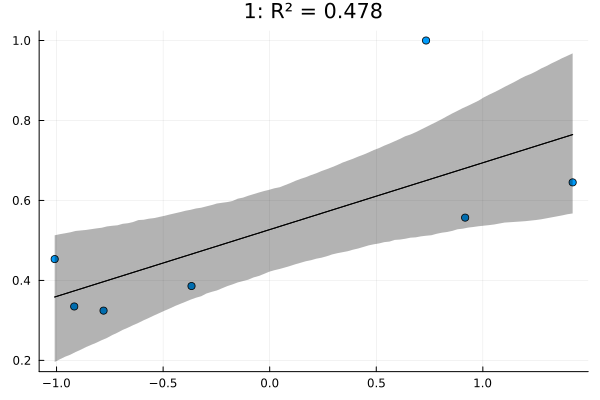

In [106]:
mass_seq = range(extrema(d.mass_std)...; length=100)
l = [
    @. r.a + r.b * mass_seq
    for r ∈ eachrow(m7_1)
]
l = vcat(l'...)
μ = mean.(eachcol(l))
ci = PI.(eachcol(l))
ci = vcat(ci'...)

scatter(d.mass_std, d.brain_std; title="1: R² = $(round(R2_is_bad(m7_1); digits=3))")
plot!(mass_seq, [μ μ]; fillrange=ci, c=:black, fillalpha=0.3)

In [110]:
# reimplemented the brand_plot function to check my results
function brain_plot(df; sigma=missing)
    degree = ncol(df[!,r"b"])
    # build mass_seq*degree matrix, with each col exponentiated to col's index
    t = repeat(mass_seq, 1, degree)
    t = hcat(map(.^, eachcol(t), 1:degree)...)
    l = [
        r.a .+ t * collect(r[r"b"])
        for r ∈ eachrow(df)
    ]
    l = vcat(l'...)
    μ = mean.(eachcol(l))
    ci = PI.(eachcol(l))
    ci = vcat(ci'...)

    r2 = round(R2_is_bad(df, sigma=sigma); digits=3)
    scatter(d.mass_std, d.brain_std; title="$degree: R² = $r2")
    plot!(mass_seq, [μ μ]; fillrange=ci, c=:black, fillalpha=0.3)
end

brain_plot (generic function with 1 method)

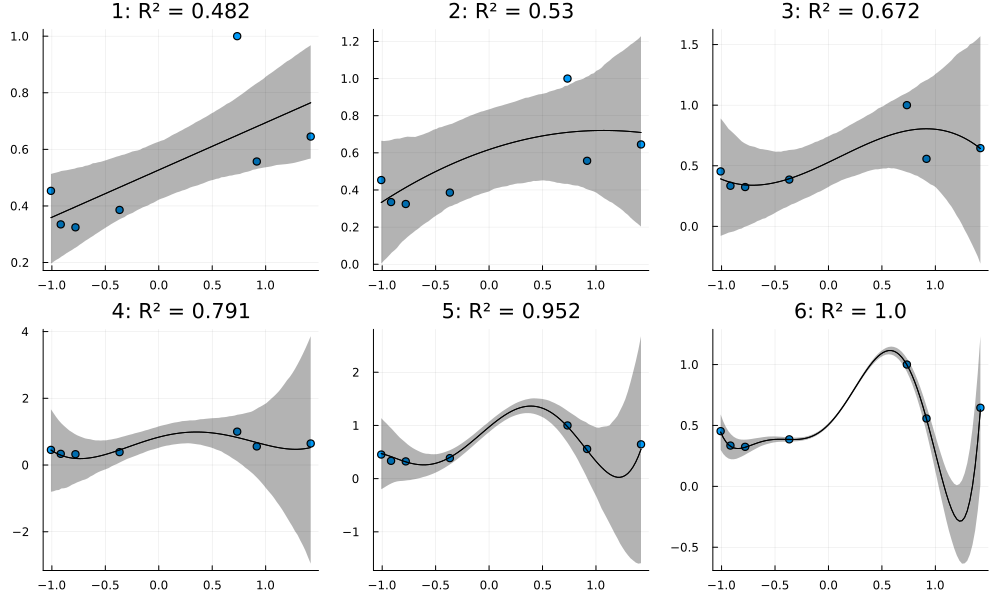

In [113]:
plot(
    brain_plot(m7_1),
    brain_plot(m7_2),
    brain_plot(m7_3),
    brain_plot(m7_4),
    brain_plot(m7_5),
    brain_plot(m7_6, sigma=0.001);
    size=(1000, 600)
)

## Code 7.11

In [114]:
i = 3
d_minus_i = d[setdiff(1:end,i),:];

In [115]:
function brain_loo_plot(model, data; title::String)
    (a, b) = extrema(data.brain_std)
    p = scatter(data.mass_std, data.brain_std; title=title, ylim=(a-0.1, b+0.1))
    mass_seq = range(extrema(data.mass_std)...; length=100)
    
    for i ∈ 1:nrow(data)
        d_minus_i = data[setdiff(1:end,i),:]
        df = DataFrame(sample(model(d_minus_i.mass_std, d_minus_i.brain_std), NUTS(), 1000))

        degree = ncol(df[!,r"b"])
        # build mass_seq*degree matrix, with each col exponentiated to col's index
        t = repeat(mass_seq, 1, degree)
        t = hcat(map(.^, eachcol(t), 1:degree)...)
        l = [
            r.a .+ t * collect(r[r"b"])
            for r ∈ eachrow(df)
        ]
        l = vcat(l'...)
        μ = mean.(eachcol(l))
        plot!(mass_seq, μ; c=:black)
    end
    p
end

brain_loo_plot (generic function with 1 method)

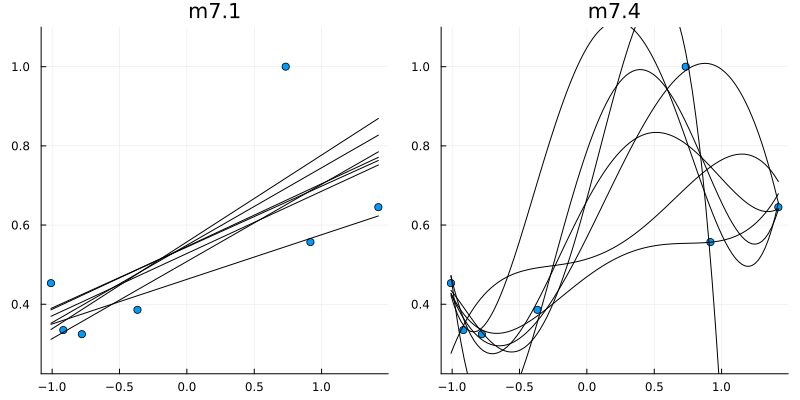

In [116]:
Random.seed!(1)

model_m7_4 = (mass, brain) -> model_m7_n(mass, brain, degree=4)

plot(
    brain_loo_plot(model_m7_1, d, title="m7.1"),
    brain_loo_plot(model_m7_4, d, title="m7.4");
    size=(800, 400)
)

# 7.2 Entropy and accuracy

## Code 7.12 Information and KL Divergence

In [117]:
p = [0.3, 0.7]
-sum(p .* log.(p))

0.6108643020548935

## Code 7.13 lppd: Log-Pointwise-Predictive-Density

In [64]:
lppd(m7_1, (r,x)->Normal(r.a + r.b*x, exp(r.log_σ)), d.mass_std, d.brain_std)

7-element Vector{Float64}:
  0.40036125684305013
  0.4258802005349356
  0.3358718536418346
  0.4138377618845279
  0.2866021254329816
  0.24913110709248354
 -0.6009225563035114

## Code 7.14

In [118]:
[
    begin
        s = [
            logpdf(Normal(r.a + r.b * x, exp(r.log_σ)), y)
            for r ∈ eachrow(m7_1)
        ]
        logsumexp(s) - log(length(s))
    end
    for (x, y) ∈ zip(d.mass_std, d.brain_std)
]

7-element Vector{Float64}:
  0.6215191229199037
  0.6533856472530237
  0.537062145687897
  0.6369010843438163
  0.455738081948855
  0.41752003923420133
 -0.8689601373135893

## Code 7.15 lppd function

In [119]:
# it could be implemented in a generic way, but I'm too lazy
df_funcs = [
    (m7_1, (r, x) -> Normal(r.a + r.b*x, exp(r.log_σ))),
    (m7_2, (r, x) -> Normal(r.a + r."b[1]" * x + r."b[2]"*x^2, exp(r.log_σ))),
    (m7_3, (r, x) -> Normal(r.a + r."b[1]" * x + r."b[2]"*x^2 + r."b[3]"*x^3, exp(r.log_σ))),
    (m7_4, (r, x) -> Normal(r.a + r."b[1]" * x + r."b[2]"*x^2 + r."b[3]"*x^3 + 
                                  r."b[4]"*x^4, exp(r.log_σ))),
    (m7_5, (r, x) -> Normal(r.a + r."b[1]" * x + r."b[2]"*x^2 + r."b[3]"*x^3 + 
                                  r."b[4]"*x^4 + r."b[5]"*x^5, exp(r.log_σ))),
    (m7_6, (r, x) -> Normal(r.a + r."b[1]" * x + r."b[2]"*x^2 + r."b[3]"*x^3 + 
                                  r."b[4]"*x^4 + r."b[5]"*x^5 + r."b[6]"*x^6, 0.001)),
];

In [120]:
[
    sum(lppd(df, f, d.mass_std, d.brain_std))
    for (df, f) ∈ df_funcs
]

6-element Vector{Float64}:
  2.453165984074108
  1.3772214848022246
  1.0962771713527442
 -3.497235839630262
  1.8252360535224508
 14.542200140042517

## Code 7.16

In [121]:
@model function m7_sim(x, y; degree::Int=2)
    beta ~ MvNormal(zeros(degree), 1)
    μ = x * beta
    y ~ MvNormal(μ, 1)
end

# Calculate lppd*(-2) from sampled params (b), x matrix and target y values
function get_lppd(m_df, xseq, yseq)
    t = DataFrame(:b => collect(eachrow(Matrix(m_df))))
    -2*sum(lppd(t, (r, x) -> Normal(r.b'*x, 1), eachrow(xseq), yseq))
end

function calc_train_test(N, k; count=100)
    trn_v, tst_v = [], []
    for _ in 1:count
        # method sim_train_test from StatisticalRethinking just simulates the data to be fitted by the model
        y, x_train, x_test = sim_train_test(N=N, K=k)

        estim = optimize(m7_sim(x_train, y, degree=max(2,k)), MAP())
        m7_2 = DataFrame(sample(estim, 1000))
        # commented out is the MCMC way of estimation instead of MAP
#         m_chain = sample(m7_sim(x_train, y, degree=max(2,k)), NUTS(), 1000)
#         m7_2 = DataFrame(m_chain)
        t1 = get_lppd(m7_2, x_train, y)
        t2 = get_lppd(m7_2, x_test, y)
        push!(trn_v, t1)
        push!(tst_v, t2)
    end
    (mean_and_std(trn_v), mean_and_std(tst_v))
end

calc_train_test (generic function with 1 method)

## Code 7.17 Multi-threading

In [128]:
k_count = 5
k_seq = 1:k_count
count = 100
trn_20, tst_20 = [], []
trn_100, tst_100 = [], []

Threads.@threads for k in k_seq
    println("Processing $k with N=20...")
    t1, t2 = calc_train_test(20, k, count=count)
    push!(trn_20, t1)
    push!(tst_20, t2)
    println("Processing $k with N=100...")
    t1, t2 = calc_train_test(100, k, count=count)
    push!(trn_100, t1)
    push!(tst_100, t2)
end

Processing 1 with N=20...
Σ_raw: [0.04015819041438828 0.0013326394744887832; 0.0013326394744887832 0.0736959539990591]
Σ: [0.04015819041438828 0.0013326394744887832; 0.0013326394744887832 0.0736959539990591]
Σ_raw: [0.04837988089178114 0.013717319047018792; 0.013717319047018792 0.06611845576287098]
Σ: [0.04837988089178114 0.013717319047018792; 0.013717319047018792 0.06611845576287098]
Σ_raw: [0.03436781076974709 0.0008112416107710056; 0.0008112416107710056 0.05077509463014094]
Σ: [0.03436781076974709 0.0008112416107710056; 0.0008112416107710056 0.05077509463014094]
Σ_raw: [0.07485514287371442 -0.006329721375037363; -0.006329721375037363 0.02648268173133108]
Σ: [0.07485514287371442 -0.006329721375037363; -0.006329721375037363 0.02648268173133108]
Σ_raw: [0.06933015386093423 -0.008208356586011252; -0.008208356586011252 0.040643968596806294]
Σ: [0.06933015386093423 -0.008208356586011252; -0.008208356586011252 0.040643968596806294]
Σ_raw: [0.04955491166858677 -0.013316585297395005; -0.0133

LoadError: TaskFailedException

[91m    nested task error: [39mPosDefException: matrix is not Hermitian; Cholesky factorization failed.
    Stacktrace:
      [1] [0m[1mcheckpositivedefinite[22m[0m[1m([22m[90minfo[39m::[0mInt64[0m[1m)[22m
    [90m    @[39m [33mLinearAlgebra[39m [90m~/.julia/juliaup/julia-1.10.2+0.x64.linux.gnu/share/julia/stdlib/v1.10/LinearAlgebra/src/[39m[90m[4mfactorization.jl:67[24m[39m
      [2] [0m[1mcholesky![22m[0m[1m([22m[90mA[39m::[0mNamedArrays.NamedMatrix[90m{Float64, Matrix{Float64}, Tuple{OrderedCollections.OrderedDict{Symbol, Int64}, OrderedCollections.OrderedDict{Symbol, Int64}}}[39m, ::[0mNoPivot; [90mcheck[39m::[0mBool[0m[1m)[22m
    [90m    @[39m [33mLinearAlgebra[39m [90m~/.julia/juliaup/julia-1.10.2+0.x64.linux.gnu/share/julia/stdlib/v1.10/LinearAlgebra/src/[39m[90m[4mcholesky.jl:298[24m[39m
      [3] [0m[1mcholesky![22m[90m (repeats 2 times)[39m
    [90m    @[39m [90m~/.julia/juliaup/julia-1.10.2+0.x64.linux.gnu/share/julia/stdlib/v1.10/LinearAlgebra/src/[39m[90m[4mcholesky.jl:295[24m[39m[90m [inlined][39m
      [4] [0m[1mcholesky[22m[90m (repeats 2 times)[39m
    [90m    @[39m [90m~/.julia/juliaup/julia-1.10.2+0.x64.linux.gnu/share/julia/stdlib/v1.10/LinearAlgebra/src/[39m[90m[4mcholesky.jl:401[24m[39m[90m [inlined][39m
      [5] [0m[1mPDMats.PDMat[22m[0m[1m([22m[90mmat[39m::[0mNamedArrays.NamedMatrix[90m{Float64, Matrix{Float64}, Tuple{OrderedCollections.OrderedDict{Symbol, Int64}, OrderedCollections.OrderedDict{Symbol, Int64}}}[39m[0m[1m)[22m
    [90m    @[39m [36mPDMats[39m [90m~/.julia/packages/PDMats/cAM9h/src/[39m[90m[4mpdmat.jl:19[24m[39m
      [6] [0m[1mMvNormal[22m[0m[1m([22m[90mμ[39m::[0mNamedArrays.NamedVector[90m{Float64, Vector{Float64}, Tuple{OrderedCollections.OrderedDict{Symbol, Int64}}}[39m, [90mΣ[39m::[0mNamedArrays.NamedMatrix[90m{Float64, Matrix{Float64}, Tuple{OrderedCollections.OrderedDict{Symbol, Int64}, OrderedCollections.OrderedDict{Symbol, Int64}}}[39m[0m[1m)[22m
    [90m    @[39m [32mDistributions[39m [90m~/.julia/packages/Distributions/UaWBm/src/multivariate/[39m[90m[4mmvnormal.jl:201[24m[39m
      [7] [0m[1msample[22m[0m[1m([22m[90mm[39m::[0mTuringOptimExt.ModeResult[90m{NamedArrays.NamedVector{Float64, Vector{Float64}, Tuple{OrderedCollections.OrderedDict{Symbol, Int64}}}, Optim.MultivariateOptimizationResults{LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}, Vector{Float64}, Float64, Float64, Vector{OptimizationState{Float64, LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}}}, Bool, @NamedTuple{f_limit_reached::Bool, g_limit_reached::Bool, h_limit_reached::Bool, time_limit::Bool, callback::Bool, f_increased::Bool}}, LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{beta::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:beta, Setfield.IdentityLens}, Int64}, Vector{IsoNormal}, Vector{AbstractPPL.VarName{:beta, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, DynamicPPL.Model{typeof(m7_sim), (:x, :y), (:degree,), (), Tuple{Matrix{Float64}, Vector{Float64}}, Tuple{Int64}, DynamicPPL.DefaultContext}, Turing.Optimisation.OptimizationContext{DynamicPPL.DefaultContext}}}[39m, [90mn[39m::[0mInt64[0m[1m)[22m
    [90m    @[39m [36mMain[39m [90m./[39m[90m[4mIn[127]:22[24m[39m
      [8] [0m[1mcalc_train_test[22m[0m[1m([22m[90mN[39m::[0mInt64, [90mk[39m::[0mInt64; [90mcount[39m::[0mInt64[0m[1m)[22m
    [90m    @[39m [36mMain[39m [90m./[39m[90m[4mIn[121]:20[24m[39m
      [9] [0m[1mmacro expansion[22m
    [90m    @[39m [90m./[39m[90m[4mIn[128]:9[24m[39m[90m [inlined][39m
     [10] [0m[1m(::var"#1045#threadsfor_fun#59"{var"#1045#threadsfor_fun#58#60"{UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m    @[39m [36mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:215[24m[39m
     [11] [0m[1m#1045#threadsfor_fun[22m
    [90m    @[39m [90m./[39m[90m[4mthreadingconstructs.jl:182[24m[39m[90m [inlined][39m
     [12] [0m[1m(::Base.Threads.var"#1#2"{var"#1045#threadsfor_fun#59"{var"#1045#threadsfor_fun#58#60"{UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:154[24m[39m

## Code 7.18 Plot the training and testing deviance

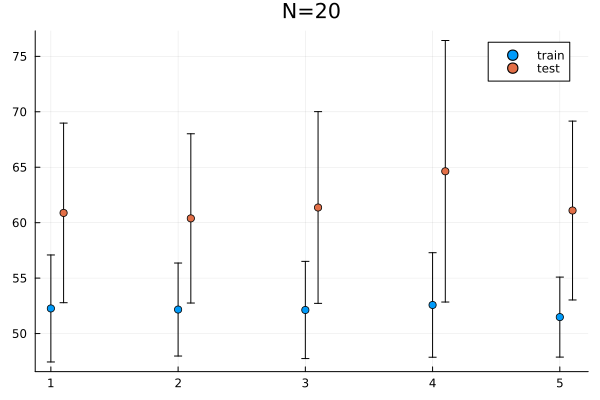

In [123]:
scatter(k_seq, first.(trn_20); yerr=last.(trn_20), label="train", title="N=20")
scatter!(k_seq .+ .1, first.(tst_20); yerr=last.(tst_20), label="test")

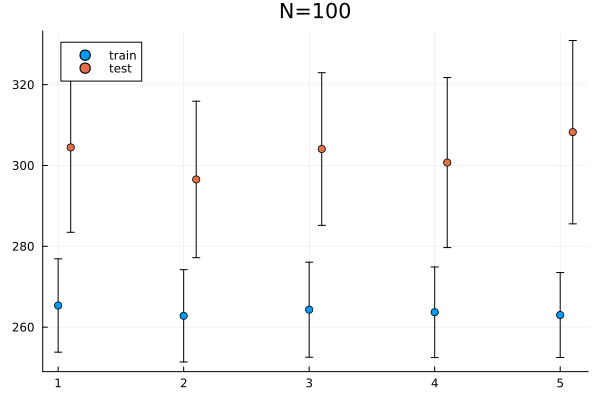

In [124]:
scatter(k_seq, first.(trn_100); yerr=last.(trn_100), label="train", title="N=100")
scatter!(k_seq .+ .1, first.(tst_100); yerr=last.(tst_100), label="test")

Hm, something is different

# 7.3 Golem taming: regularization

No code pieces in this section

# 7.4 Predicting predictive accuracy

#### Code 7.19 Monte Carlo of a Bayesian Linear Model


In [27]:
d = DataFrame(CSV.File("data/cars.csv", drop=["Column1"]))

@model function model_m(speed, dist)
    a ~ Normal(0, 100)
    b ~ Normal(0, 10)
    μ = @. a + b * speed 
    σ ~ Exponential(1)
    dist ~ MvNormal(μ, σ)
end

Random.seed!(17)
m_ch = sample(model_m(d.speed, d.dist), NUTS(), 1000)
m_df = DataFrame(m_ch);

## Code 7.20 logprob

In [28]:
fun = (r, (x, y)) -> normlogpdf(r.a + r.b * x, r.σ, y)
lp = link(m_df, fun, zip(d.speed, d.dist))
lp = hcat(lp...);

## Code 7.21 lppd

In [29]:
n_samples, n_cases = size(lp)
lppd_vals = [
    logsumexp(c) - log(n_samples)
    for c in eachcol(lp)
];

## if only lppd were needed, we can calculate it with
# lppd_vals = lppd(m_df, (r, x) -> Normal(r.a + r.b * x, r.σ), d.speed, d.dist)

## Code 7.22 penalty of WAIC

In [30]:
pWAIC = [
    StatisticalRethinking.var2(c)
    for c in eachcol(lp)
];

## Code 7.23 WAIC

In [31]:
-2*(sum(lppd_vals) - sum(pWAIC))

421.24440925699935

## Code 7.24 stddev of WAIC

In [32]:
waic_vec = -2*(lppd_vals .- pWAIC)
sqrt(n_cases * StatisticalRethinking.var2(waic_vec))

16.13284428811226

# 7.5 Model comparison

Data and models from chapter 6

In [33]:
Random.seed!(70)
# number of plants
N = 100
h0 = rand(Normal(10, 2), N)
treatment = repeat(0:1, inner=div(N, 2))
fungus = [rand(Binomial(1, 0.5 - treat*0.4)) for treat in treatment]
h1 = h0 .+ rand(MvNormal(5 .- 3 .* fungus, 1))

d = DataFrame(:h0 => h0, :h1 => h1, :treatment => treatment, :fungus => fungus)

@model function model_m6_6(h0, h1)
    p ~ LogNormal(0, 0.25)
    σ ~ Exponential(1)
    μ = h0 .* p
    h1 ~ MvNormal(μ, σ)
end

m6_6 = sample(model_m6_6(d.h0, d.h1), NUTS(), 1000)
m6_6_df = DataFrame(m6_6)

@model function model_m6_7(h0, treatment, fungus, h1)
    a ~ LogNormal(0, 0.2)
    bt ~ Normal(0, 0.5)
    bf ~ Normal(0, 0.5)
    σ ~ Exponential(1)
    p = @. a + bt*treatment + bf*fungus
    μ = h0 .* p
    h1 ~ MvNormal(μ, σ)
end

m6_7 = sample(model_m6_7(d.h0, d.treatment, d.fungus, d.h1), NUTS(), 1000)
m6_7_df = DataFrame(m6_7)

@model function model_m6_8(h0, treatment, h1)
    a ~ LogNormal(0, 0.2)
    bt ~ Normal(0, 0.5)
    σ ~ Exponential(1)
    p = @. a + bt*treatment
    μ = h0 .* p
    h1 ~ MvNormal(μ, σ)
end

m6_8 = sample(model_m6_8(d.h0, d.treatment, d.h1), NUTS(), 1000)
m6_8_df = DataFrame(m6_8);

## Code 7.25 WAIC for m6_7 (include both treatment and fungus)

In [34]:
fun = (r, (x,bt,bf,y)) -> normlogpdf(x*(r.a + r.bt*bt + r.bf*bf), r.σ, y)

# log likelihood calculation
ll = link(m6_7_df, fun, zip(d.h0, d.treatment, d.fungus, d.h1));
ll = hcat(ll...);

waic(ll)

(WAIC = 325.0325798695998, lppd = -158.9846099932586, penalty = 3.5316799415412317, std_err = 13.436867558736525)

## Code 7.26 Compare WAIC of m6.6 - m6.8

In [35]:
fun = (r, (x,y)) -> normlogpdf(x*r.p, r.σ, y)
m6_ll = link(m6_6_df, fun, zip(d.h0, d.h1));
m6_ll = hcat(m6_ll...);

fun = (r, (x,bt,bf,y)) -> normlogpdf(x*(r.a + r.bt*bt + r.bf*bf), r.σ, y)
m7_ll = link(m6_7_df, fun, zip(d.h0, d.treatment, d.fungus, d.h1));
m7_ll = hcat(m7_ll...);

fun = (r, (x,bt,y)) -> normlogpdf(x*(r.a + r.bt*bt), r.σ, y)
m8_ll = link(m6_8_df, fun, zip(d.h0, d.treatment, d.h1));
m8_ll = hcat(m8_ll...);

compare([m6_ll, m7_ll, m8_ll], :waic, mnames=["m6", "m7", "m8"])

,models,WAIC,lppd,SE,dWAIC,dSE,pWAIC,weight
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,m7,325.0,317.97,13.44,0.0,0.0,3.53,1.0
2,m8,398.0,392.39,13.11,73.0,13.25,2.81,0.0
3,m6,407.4,404.19,12.04,82.4,12.55,1.6,0.0


## Code 7.27  stddev of WAIC delta between m6.7 and m6.8

In [36]:
waic_m6_7 = waic(m7_ll, pointwise=true).WAIC
waic_m6_8 = waic(m8_ll, pointwise=true).WAIC
n = length(waic_m6_7)
diff_m6_78 = waic_m6_7 - waic_m6_8
sqrt(n*StatisticalRethinking.var2(diff_m6_78))

13.185345701175946

## Code 7.28 99% confidence interval of dWAIC

In [37]:
 40.0 .+ [-1, 1]*10.4*2.6

2-element Vector{Float64}:
 12.959999999999997
 67.04

## Code 7.29 plot WAIC/deviance of 3 different models

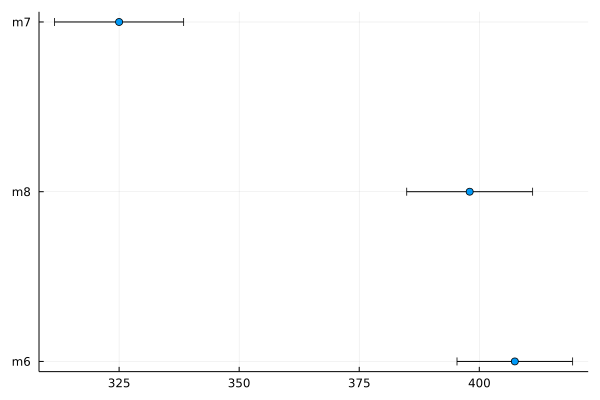

In [38]:
dw = compare([m6_ll, m7_ll, m8_ll], :waic, mnames=["m6", "m7", "m8"])
scatter(reverse(dw.WAIC), reverse(dw.models); xerror=reverse(dw.SE))

## Code 7.30 stddev of WAIC differences between m6.6 and m6.8

In [39]:
waic_m6_6 = waic(m6_ll, pointwise=true).WAIC
waic_m6_8 = waic(m8_ll, pointwise=true).WAIC
diff_m6_68 = waic_m6_6 - waic_m6_8
sqrt(n*StatisticalRethinking.var2(diff_m6_68))

7.034765844799374

## Code 7.31 stddev of WAIC differences among all models

Current version of `StatisticalRethinking.compare` doesn't calculate pairwise error. You should use above logic to get values not returned in `compare` result.

## Code 7.32 3 models of Divorce rate, Marriage rate, Age at Marraige.

In [40]:
Random.seed!(1)
d = DataFrame(CSV.File("data/WaffleDivorce.csv"))
d[!,:D] = standardize(ZScoreTransform, d.Divorce)
d[!,:M] = standardize(ZScoreTransform, d.Marriage)
d[!,:A] = standardize(ZScoreTransform, d.MedianAgeMarriage)

@model function model_m5_1(A, D)
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bA ~ Normal(0, 0.5)
    μ = @. a + bA * A
    D ~ MvNormal(μ, σ)
end

m5_1 = sample(model_m5_1(d.A, d.D), NUTS(), 1000)
m5_1_df = DataFrame(m5_1)

@model function model_m5_2(M, D)
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bM ~ Normal(0, 0.5)
    μ = @. a + bM * M
    D ~ MvNormal(μ, σ)
end

m5_2 = sample(model_m5_2(d.M, d.D), NUTS(), 1000)
m5_2_df = DataFrame(m5_2);

@model function model_m5_3(A, M, D)
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bA ~ Normal(0, 0.5)
    bM ~ Normal(0, 0.5)
    μ = @. a + bA * A + bM * M
    D ~ MvNormal(μ, σ)
end

m5_3 = sample(model_m5_3(d.A, d.M, d.D), NUTS(), 1000)
m5_3_df = DataFrame(m5_3);

In [41]:
fun = (r, (x,y)) -> normlogpdf(r.a + r.bA * x, r.σ, y)
m5_1_ll = link(m5_1_df, fun, zip(d.A, d.D));
m5_1_ll = hcat(m5_1_ll...)

fun = (r, (x,y)) -> normlogpdf(r.a + r.bM * x, r.σ, y)
m5_2_ll = link(m5_2_df, fun, zip(d.M, d.D));
m5_2_ll = hcat(m5_2_ll...)

fun = (r, (a,m,y)) -> normlogpdf(r.a + r.bA * a + r.bM * m, r.σ, y)
m5_3_ll = link(m5_3_df, fun, zip(d.A, d.M, d.D));
m5_3_ll = hcat(m5_3_ll...);

## Code 7.33

In [42]:
compare([m5_1_ll, m5_2_ll, m5_3_ll], :psis, mnames=["m5.1", "m5.2", "m5.3"])

,models,PSIS,lppd,SE,dPSIS,dSE,pPSIS,weight
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,m5.1,125.2,118.43,12.29,0.0,0.0,3.62,0.69
2,m5.3,126.8,118.12,12.21,1.6,0.71,4.68,0.31
3,m5.2,138.7,133.38,9.7,13.5,8.85,2.88,0.0


## Code 7.34

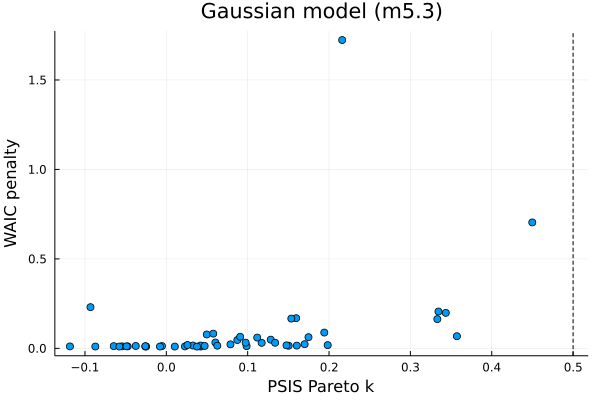

In [43]:
using ParetoSmooth

# reshape data to format of psis_loo function
function ll_to_psis(ll)
    t = ll'
    collect(reshape(t, size(t)..., 1))
end

m5_3_t = ll_to_psis(m5_3_ll)
PSIS_m5_3 = psis_loo(m5_3_t)
WAIC_m5_3 = waic(m5_3_ll, pointwise=true)

scatter(PSIS_m5_3.pointwise(:pareto_k), WAIC_m5_3.penalty, 
    xlab="PSIS Pareto k", ylab="WAIC penalty", title="Gaussian model (m5.3)")
vline!([0.5], c=:black, s=:dash)

## Code 7.35

In [44]:
# have to import it explicitly, as it is not exported
import Distributions: IsoTDist

@model function model_m5_3t(A, M, D)
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bA ~ Normal(0, 0.5)
    bM ~ Normal(0, 0.5)
    μ = @. a + bA * A + bM * M
    D ~ IsoTDist(2, μ, σ)
end

m5_3t = sample(model_m5_3t(d.A, d.M, d.D), NUTS(), 1000)
m5_3t_df = DataFrame(m5_3);

### Visualize PSIS

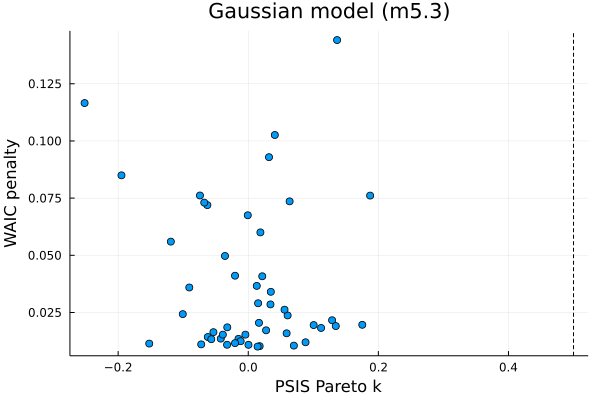

In [45]:
fun = (r, (a,m,y)) -> logpdf(IsoTDist(2, [r.a + r.bA * a + r.bM * m], r.σ), [y])
m5_3t_ll = link(m5_3t_df, fun, zip(d.A, d.M, d.D));
m5_3t_ll = hcat(m5_3t_ll...);

m5_3t_t = ll_to_psis(m5_3t_ll)
PSIS_m5_3t = psis_loo(m5_3t_t)
WAIC_m5_3t = waic(m5_3t_ll, pointwise=true)

scatter(PSIS_m5_3t.pointwise(:pareto_k), WAIC_m5_3t.penalty, 
    xlab="PSIS Pareto k", ylab="WAIC penalty", title="Gaussian model (m5.3)")
vline!([0.5], c=:black, s=:dash)